<a href="https://colab.research.google.com/github/NicolasGSR/analise-mercado-imobiliario/blob/main/mercado_imo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [4]:
# Definir o cabeçalho para a requisição HTTP, simulando um navegador real
header = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/132.0.0.0 Safari/537.36'
}

# Definir URL da API SIDRA do IBGE contendo os dados sobre empresas de construção
url_sidra = 'https://apisidra.ibge.gov.br/values/t/1757/n1/all/n2/all/v/631/p/first%2014/c319/104029'

# Fazer a requisição HTTP para obter os dados da API
response_sidra = requests.get(url_sidra, headers=header)

# Converter a resposta JSON para um dicionário Python
data_construcao = response_sidra.json()

# Carregar o arquivo do IBGE contendo dados de população por idade
populacao_df = pd.read_excel('/content/projecoes_2024_tab1_idade_simples (1).xlsx')

# Converter os dados da API SIDRA em um DataFrame do Pandas
empresas_df = pd.json_normalize(data_construcao)

# Preparar os DataFrames
empresas_df = empresas_df.drop(columns=['NC', 'MC', 'D1C', 'NN', 'D2C', 'D2N', 'D3C', 'D4C', 'D4N', 'MN'])
empresas_df = empresas_df.drop([0])
empresas_df = empresas_df.rename(columns={"V": "Trabalhadores", "D1N": "Estado", "D3N": "Ano"})
empresas_df = empresas_df[['Ano', 'Estado', 'Trabalhadores']]
populacao_df = populacao_df.drop([0, 1, 2, 3])
populacao_df = populacao_df.drop(columns={'Unnamed: 1'})
populacao_df = populacao_df.applymap(lambda x: int(x) if isinstance(x, (int, float)) else x)
populacao_df.columns = populacao_df.iloc[0]
populacao_df = populacao_df[1:].reset_index(drop=True)
populacao_df = populacao_df.rename(columns={'IDADE': 'Faixa Etaria', 'LOCAL': 'Estado'})


<ipython-input-4-72653043eb58>:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  populacao_df = populacao_df.applymap(lambda x: int(x) if isinstance(x, (int, float)) else x)


In [5]:
# Verificar DataFrame da população
populacao_df.head()

4,Faixa Etaria,Estado,2000,2001,2002,2003,2004,2005,2006,2007,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,0,Brasil,3423475,3347313,3274356,3212295,3163041,3123546,3095244,3013232,...,2922850,2952907,3012970,2948637,2883226,2920425,2885318,2777978,2688491,2597799
1,1,Brasil,3450022,3406966,3332612,3261091,3200484,3152623,3114345,3087163,...,2925710,2913563,2943154,3002376,2937001,2870232,2910089,2879163,2772134,2680031
2,2,Brasil,3461038,3444450,3401900,3327924,3256791,3196543,3149015,3111038,...,2904628,2920488,2907915,2936667,2995070,2928703,2863990,2906676,2876276,2767175
3,3,Brasil,3469109,3458052,3441638,3399284,3325501,3254582,3194489,3147097,...,2891454,2901225,2916787,2903600,2931742,2989393,2924609,2862071,2904924,2873055
4,4,Brasil,3477903,3466901,3455987,3439662,3397467,3323811,3253080,3193054,...,2940420,2889030,2898606,2913739,2900133,2927764,2986627,2923442,2861079,2902777


In [6]:
# Verificar DataFrame dos trabalhadores das empresas de contrução
empresas_df.head()

,Ano,Estado,Trabalhadores
1,2007,Brasil,1604331
2,2008,Brasil,1799556
3,2009,Brasil,2069815
4,2010,Brasil,2457809
5,2011,Brasil,2658643


In [7]:
# Selecionar apenas as faixas etárias entre 38 e 58 anos
faixa_etaria = list(range(38, 59))  # 38 a 58 anos
populacao_filtrada = populacao_df[populacao_df['Faixa Etaria'].isin(faixa_etaria)]

# Agrupar por Estado e somar a população dessa faixa etária para cada ano
populacao_agrupada = populacao_filtrada.groupby('Estado').sum(numeric_only=True).reset_index()

estados = ['Acre', 'Alagoas', 'Amazonas', 'Amapá', 'Bahia', 'Ceará', 'Distrito Federal', 'Espírito Santo', 'Goiás',
           'Maranhão', 'Minas Gerais', 'Mato Grosso do Sul', 'Mato Grosso', 'Pará', 'Paraíba', 'Pernambuco',
           'Piauí', 'Paraná', 'Rio de Janeiro', 'Rio Grande do Norte', 'Rondônia', 'Roraima', 'Rio Grande do Sul',
           'Santa Catarina', 'Sergipe', 'São Paulo', 'Tocantins']

# Criar um padrão regex com as palavras da lista de estados
pattern = '|'.join(estados)

# Filtrar o DataFrame para remover linhas com estados
populacao_agrupada = populacao_agrupada[~populacao_agrupada['Estado'].str.contains(pattern, regex=True)]

# Preparar o DataFrame
populacao_agrupada = populacao_agrupada.set_index('Estado').T
populacao_agrupada.index.name = 'Ano'
populacao_agrupada = populacao_agrupada.transpose()
populacao_agrupada = populacao_agrupada.drop(columns=[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2021, 2022])

# Verificar o formato após a agregação
populacao_agrupada.head()

Ano,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Estado,,,,,,,,,,,,,,
Brasil,89275116,91348084,93367056,95316158,97189920,99035690,100886424,102779554,104736296,106766886,108850478,110945618,113019996,114979606
Centro-Oeste,6318814,6531076,6742144,6949556,7153440,7358534,7566058,7778030,7995416,8218806,8446442,8674768,8900740,9116328
Nordeste,21887716,22439020,22993456,23547758,24096334,24648978,25215896,25806068,26425298,27074400,27743520,28416992,29083868,29718750
Norte,5591294,5800864,6012956,6225178,6437310,6653258,6875174,7104092,7339984,7582754,7831892,8086706,8346270,8596692
Sudeste,41134420,41960794,42748892,43492108,44190184,44864190,45527188,46195870,46879002,47582768,48301158,49017200,49718706,50370550


In [8]:
# Agrupar os dados por Estado e Ano, somando o número de empresas
empresas_agrupadas = empresas_df.groupby(['Estado', 'Ano'])['Trabalhadores'].sum().reset_index()

# Exibir o resultado após o agrupamento
empresas_agrupadas.head()

,Estado,Ano,Trabalhadores
0,Brasil,2007,1604331
1,Brasil,2008,1799556
2,Brasil,2009,2069815
3,Brasil,2010,2457809
4,Brasil,2011,2658643


In [9]:
# Pivotar os dados para transformar os anos em colunas
empresas_agrupadas_pivot = empresas_agrupadas.pivot(index='Estado', columns='Ano', values='Trabalhadores')

# Exibir o novo formato
empresas_agrupadas_pivot.head()

Ano,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Estado,,,,,,,,,,,,,,
Brasil,1604331,1799556,2069815,2457809,2658643,2858180,2968136,2891141,2439997,2000884,1901554,1873561,1906174,1981698
Centro-Oeste,113428,128732,152071,188737,202986,228352,235800,216039,174303,154082,137291,141760,136009,144715
Nordeste,269348,296928,358174,470383,530591,559139,586055,586820,492726,392573,365897,341702,313233,328297
Norte,68197,73375,84771,98843,107918,117407,133468,122092,98577,77282,74896,78202,67346,73325
Sudeste,943217,1059301,1191272,1371167,1461878,1556674,1594253,1536599,1293379,1028485,1002657,994139,1060962,1091954


In [10]:
# Renomear as colunas de 'populacao_agrupada' para adicionar '_pop'
populacao_agrupada = populacao_agrupada.rename(columns=lambda x: f"{x}_pop" if x != "Regiao" else x)

# Renomear as colunas de 'empresas_agrupadas_pivot' para adicionar '_emp'
empresas_agrupadas_pivot = empresas_agrupadas_pivot.rename(columns=lambda x: f"{x}_emp" if x != "Regiao" else x)

# Verificar os nomes das colunas para garantir que estão corretos
populacao_agrupada.columns, empresas_agrupadas_pivot.columns

(Index(['2007_pop', '2008_pop', '2009_pop', '2010_pop', '2011_pop', '2012_pop',
        '2013_pop', '2014_pop', '2015_pop', '2016_pop', '2017_pop', '2018_pop',
        '2019_pop', '2020_pop'],
       dtype='object', name='Ano'),
 Index(['2007_emp', '2008_emp', '2009_emp', '2010_emp', '2011_emp', '2012_emp',
        '2013_emp', '2014_emp', '2015_emp', '2016_emp', '2017_emp', '2018_emp',
        '2019_emp', '2020_emp'],
       dtype='object', name='Ano'))

In [11]:
# Realizar o merge entre os dois DataFrames
dados_combinados = pd.merge(populacao_agrupada, empresas_agrupadas_pivot, left_index=True, right_index=True)

# Visualizar as colunas após o merge
dados_combinados.columns

Index(['2007_pop', '2008_pop', '2009_pop', '2010_pop', '2011_pop', '2012_pop',
       '2013_pop', '2014_pop', '2015_pop', '2016_pop', '2017_pop', '2018_pop',
       '2019_pop', '2020_pop', '2007_emp', '2008_emp', '2009_emp', '2010_emp',
       '2011_emp', '2012_emp', '2013_emp', '2014_emp', '2015_emp', '2016_emp',
       '2017_emp', '2018_emp', '2019_emp', '2020_emp'],
      dtype='object', name='Ano')

In [12]:
# Garantir que as colunas de população e empresas sejam numéricas
for ano in range(2007, 2021):
    coluna_pop = f'{ano}_pop'
    coluna_emp = f'{ano}_emp'

    # Converter as colunas para numérico, caso ainda não estejam
    dados_combinados[coluna_pop] = pd.to_numeric(dados_combinados[coluna_pop], errors='coerce')
    dados_combinados[coluna_emp] = pd.to_numeric(dados_combinados[coluna_emp], errors='coerce')

    # Calcular a razão
    dados_combinados[f'Razao_{ano}'] = dados_combinados[coluna_pop] / dados_combinados[coluna_emp]

# Visualizar o DataFrame com as razões
dados_combinados.head()

Ano,2007_pop,2008_pop,2009_pop,2010_pop,2011_pop,2012_pop,2013_pop,2014_pop,2015_pop,2016_pop,...,Razao_2011,Razao_2012,Razao_2013,Razao_2014,Razao_2015,Razao_2016,Razao_2017,Razao_2018,Razao_2019,Razao_2020
Estado,,,,,,,,,,,,,,,,,,,,,
Brasil,89275116,91348084,93367056,95316158,97189920,99035690,100886424,102779554,104736296,106766886,...,36.556213,34.649914,33.989825,35.549824,42.924764,53.359858,57.242907,59.216443,59.291542,58.020751
Centro-Oeste,6318814,6531076,6742144,6949556,7153440,7358534,7566058,7778030,7995416,8218806,...,35.241051,32.224522,32.086760,36.002898,45.870788,53.340468,61.522183,61.193341,65.442287,62.995045
Nordeste,21887716,22439020,22993456,23547758,24096334,24648978,25215896,25806068,26425298,27074400,...,45.414140,44.083811,43.026501,43.976122,53.630817,68.966536,75.823305,83.163084,92.850587,90.523977
Norte,5591294,5800864,6012956,6225178,6437310,6653258,6875174,7104092,7339984,7582754,...,59.650012,56.668325,51.511778,58.186384,74.459397,98.117983,104.570231,103.407918,123.931191,117.240941
Sudeste,41134420,41960794,42748892,43492108,44190184,44864190,45527188,46195870,46879002,47582768,...,30.228367,28.820543,28.557066,30.063712,36.245371,46.264912,48.173162,49.306184,46.861910,46.128820


In [13]:
# Visualizar as colunas após adição da razão
dados_combinados.columns

Index(['2007_pop', '2008_pop', '2009_pop', '2010_pop', '2011_pop', '2012_pop',
       '2013_pop', '2014_pop', '2015_pop', '2016_pop', '2017_pop', '2018_pop',
       '2019_pop', '2020_pop', '2007_emp', '2008_emp', '2009_emp', '2010_emp',
       '2011_emp', '2012_emp', '2013_emp', '2014_emp', '2015_emp', '2016_emp',
       '2017_emp', '2018_emp', '2019_emp', '2020_emp', 'Razao_2007',
       'Razao_2008', 'Razao_2009', 'Razao_2010', 'Razao_2011', 'Razao_2012',
       'Razao_2013', 'Razao_2014', 'Razao_2015', 'Razao_2016', 'Razao_2017',
       'Razao_2018', 'Razao_2019', 'Razao_2020'],
      dtype='object', name='Ano')

In [14]:
# Criar um array de anos (como números inteiros)
anos_disponiveis = np.array(range(2007, 2021)).reshape(-1, 1)  # 2007 a 2020
anos_futuros = np.array([2021, 2022]).reshape(-1, 1)  # Anos a prever

# Criar um loop para cada região e ajustar um modelo de regressão
for index, row in dados_combinados.iterrows():
    # Selecionar os valores conhecidos da razão
    valores_conhecidos = row[[f'Razao_{ano}' for ano in range(2007, 2021)]].values.reshape(-1, 1)

    # Criar e treinar o modelo
    modelo = LinearRegression()
    modelo.fit(anos_disponiveis, valores_conhecidos)

    # Prever 2021 e 2022
    previsoes = modelo.predict(anos_futuros).flatten()

    # Atribuir as previsões ao dataframe
    dados_combinados.loc[index, 'Razao_2021'] = previsoes[0]
    dados_combinados.loc[index, 'Razao_2022'] = previsoes[1]

# Exibir os últimos anos para conferência
dados_combinados[[f'Razao_{ano}' for ano in range(2018, 2023)]].head()

Ano,Razao_2018,Razao_2019,Razao_2020,Razao_2021,Razao_2022
Estado,,,,,
Brasil,59.216443,59.291542,58.020751,55.319805,56.399592
Centro-Oeste,61.193341,65.442287,62.995045,59.918953,61.493691
Nordeste,83.163084,92.850587,90.523977,78.515196,80.292952
Norte,103.407918,123.931191,117.240941,111.089208,115.018231
Sudeste,49.306184,46.861910,46.128820,46.134360,47.128687


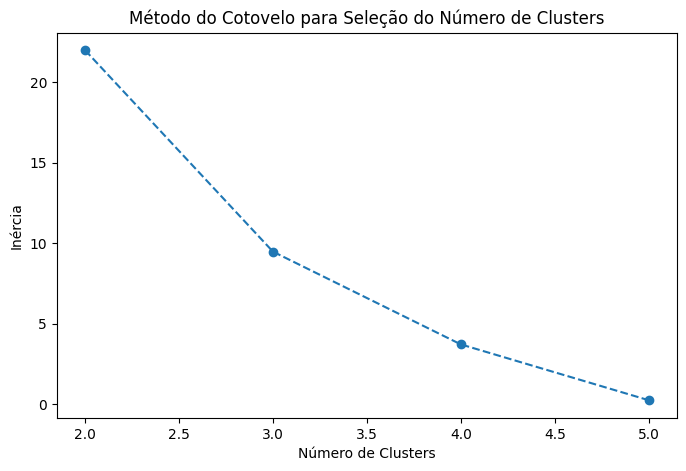

In [15]:
# Selecionar apenas os dados de razão (de 2007 a 2022)
colunas_razao = [f'Razao_{ano}' for ano in range(2007, 2023)]
dados_cluster = dados_combinados[colunas_razao]

# Normalizar os dados (para evitar viés por escalas diferentes)
scaler = StandardScaler()
dados_cluster_normalizado = scaler.fit_transform(dados_cluster)

# Definir intervalo válido para o número de clusters
num_samples = dados_cluster.shape[0]  # Número de regiões disponíveis
max_clusters = min(10, num_samples)  # Garantir que não exceda n_samples

# Determinar o número ideal de clusters pelo método do cotovelo
inercia = []
for k in range(2, max_clusters):  # Corrigindo para um intervalo válido
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(dados_cluster_normalizado)
    inercia.append(kmeans.inertia_)

# Plotar gráfico do método do cotovelo
plt.figure(figsize=(8, 5))
plt.plot(range(2, max_clusters), inercia, marker='o', linestyle='--')
plt.xlabel("Número de Clusters")
plt.ylabel("Inércia")
plt.title("Método do Cotovelo para Seleção do Número de Clusters")
plt.show()

In [16]:
# Definir número ideal de clusters (suponha que o melhor seja 3)
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
dados_combinados['Cluster'] = kmeans.fit_predict(dados_cluster_normalizado)

# Visualizar os grupos
dados_combinados[['Cluster'] + colunas_razao].head()

Ano,Cluster,Razao_2007,Razao_2008,Razao_2009,Razao_2010,Razao_2011,Razao_2012,Razao_2013,Razao_2014,Razao_2015,Razao_2016,Razao_2017,Razao_2018,Razao_2019,Razao_2020,Razao_2021,Razao_2022
Estado,,,,,,,,,,,,,,,,,
Brasil,0,55.646320,50.761457,45.108889,38.780946,36.556213,34.649914,33.989825,35.549824,42.924764,53.359858,57.242907,59.216443,59.291542,58.020751,55.319805,56.399592
Centro-Oeste,0,55.707709,50.733897,44.335501,36.821376,35.241051,32.224522,32.086760,36.002898,45.870788,53.340468,61.522183,61.193341,65.442287,62.995045,59.918953,61.493691
Nordeste,2,81.261847,75.570576,64.196329,50.060819,45.414140,44.083811,43.026501,43.976122,53.630817,68.966536,75.823305,83.163084,92.850587,90.523977,78.515196,80.292952
Norte,1,81.987389,79.057772,70.931757,62.980464,59.650012,56.668325,51.511778,58.186384,74.459397,98.117983,104.570231,103.407918,123.931191,117.240941,111.089208,115.018231
Sudeste,0,43.610770,39.611776,35.885081,31.719045,30.228367,28.820543,28.557066,30.063712,36.245371,46.264912,48.173162,49.306184,46.861910,46.128820,46.134360,47.128687


In [17]:
# Ordenar os estados/regiões pelo valor da razão em 2021
dados_saturacao_2021 = dados_combinados[['Cluster', 'Razao_2021']].sort_values(by='Razao_2021')

# Definir limites para identificar saturação e oportunidades
percentil_baixo_2021 = dados_saturacao_2021['Razao_2021'].quantile(0.25)  # 25% menores valores
percentil_alto_2021 = dados_saturacao_2021['Razao_2021'].quantile(0.75)   # 25% maiores valores

# Criar uma nova coluna categorizando os mercados
def classificar_mercado_2021(valor):
    if valor <= percentil_baixo_2021:
        return "Saturado"
    elif valor >= percentil_alto_2021:
        return "Alta Oportunidade"
    else:
        return "Neutro"

dados_combinados['Classificacao_Mercado'] = dados_combinados['Razao_2021'].apply(classificar_mercado_2021)

# Exibir os estados/regiões mais saturadas e com mais oportunidades
print("Mercados Saturados em 2021:")
print(dados_combinados[dados_combinados['Classificacao_Mercado'] == "Saturado"][['Razao_2021']])

print("\nMaiores Oportunidades em 2021:")
print(dados_combinados[dados_combinados['Classificacao_Mercado'] == "Alta Oportunidade"][['Razao_2021']])

Mercados Saturados em 2021:
Ano      Razao_2021
Estado             
Sudeste   46.134360
Sul       44.096817

Maiores Oportunidades em 2021:
Ano       Razao_2021
Estado              
Nordeste   78.515196
Norte     111.089208


In [18]:
# Ordenar os estados/regiões pelo valor da razão em 2022
dados_saturacao_2022 = dados_combinados[['Cluster', 'Razao_2022']].sort_values(by='Razao_2022')

# Definir limites para identificar saturação e oportunidades
percentil_baixo_2022 = dados_saturacao_2022['Razao_2022'].quantile(0.25)  # 25% menores valores
percentil_alto_2022 = dados_saturacao_2022['Razao_2022'].quantile(0.75)   # 25% maiores valores

# Criar uma nova coluna categorizando os mercados
def classificar_mercado_2022(valor):
    if valor <= percentil_baixo_2022:
        return "Saturado"
    elif valor >= percentil_alto_2022:
        return "Alta Oportunidade"
    else:
        return "Neutro"

dados_combinados['Classificacao_Mercado'] = dados_combinados['Razao_2022'].apply(classificar_mercado_2022)

# Exibir os estados/regiões mais saturadas e com mais oportunidades
print("Mercados Saturados em 2022:")
print(dados_combinados[dados_combinados['Classificacao_Mercado'] == "Saturado"][['Razao_2022']])

print("\nMaiores Oportunidades em 2022:")
print(dados_combinados[dados_combinados['Classificacao_Mercado'] == "Alta Oportunidade"][['Razao_2022']])

Mercados Saturados em 2022:
Ano      Razao_2022
Estado             
Sudeste   47.128687
Sul       43.510650

Maiores Oportunidades em 2022:
Ano       Razao_2022
Estado              
Nordeste   80.292952
Norte     115.018231


In [19]:
# Selecionar os dados mais recentes (2022)
df_classificacao = dados_combinados[['Razao_2022']].reset_index()

# Definir a média da razão como referência
media_razao = df_classificacao['Razao_2022'].mean()

# Criar uma nova coluna 'Status' para classificar os mercados
df_classificacao['Status'] = df_classificacao['Razao_2022'].apply(lambda x: 'Oportunidade' if x > media_razao else 'Saturado')

# Remover a linha onde 'Estado' é 'Brasil'
df_classificacao = df_classificacao[df_classificacao['Estado'] != 'Brasil']

# Visualizar os dados
print(df_classificacao)

Ano        Estado  Razao_2022        Status
1    Centro-Oeste   61.493691      Saturado
2        Nordeste   80.292952  Oportunidade
3           Norte  115.018231  Oportunidade
4         Sudeste   47.128687      Saturado
5             Sul   43.510650      Saturado


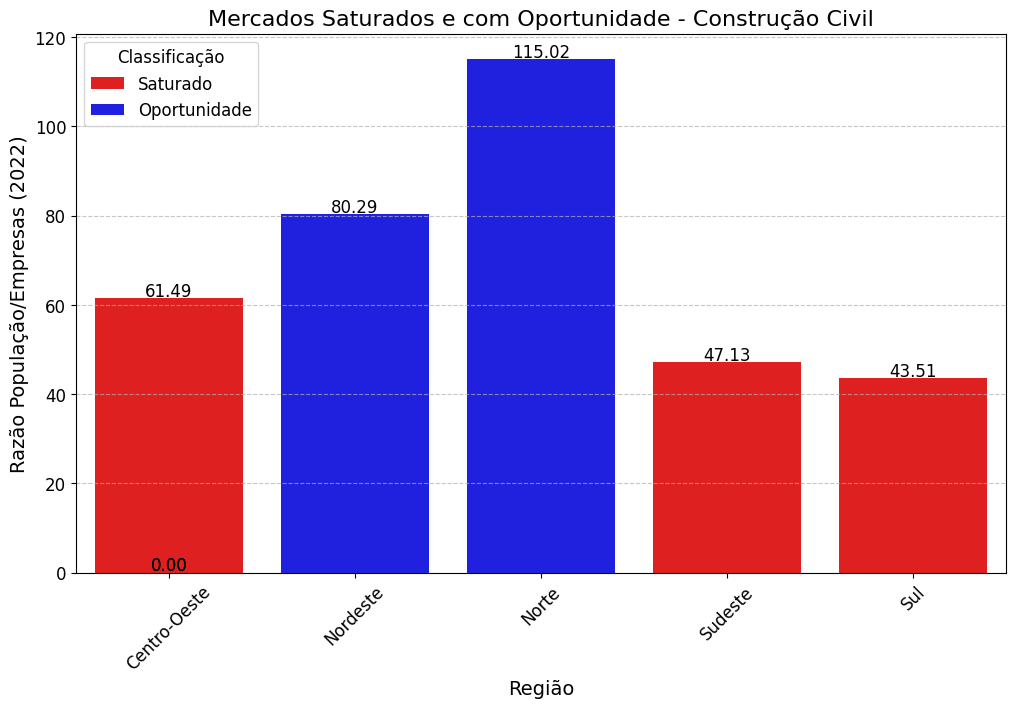

In [20]:
# Definir cores personalizadas para os status
cores = {'Oportunidade': 'blue', 'Saturado': 'red'}

# Criar o gráfico de barras
plt.figure(figsize=(12, 7))
sns.barplot(data=df_classificacao, x='Estado', y='Razao_2022', hue='Status', palette=cores)

# Adicionar rótulos e título
plt.xlabel('Região', fontsize=14)
plt.ylabel('Razão População/Empresas (2022)', fontsize=14)
plt.title('Mercados Saturados e com Oportunidade - Construção Civil', fontsize=16)

# Rotacionar os nomes das regiões para melhor visualização
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Adicionar uma grade para melhor visualização
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adicionar anotações nas barras
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=12, color='black',
                       xytext=(0, 5), textcoords='offset points')

# Personalizar a legenda
plt.legend(title='Classificação', title_fontsize=12, fontsize=12, loc='upper left')

# Exibir o gráfico
plt.show()